# A deep dive into a simple function evaluation

- To illustrate how the *Julia* language allows for functions or methods defined at a high level to be compiled, we consider, in great detail, a simple example.
- The *logistic* function, $g^{-1}(x) = \frac{1}{1 + \exp(-x)}$, will be called on a *linear predictor* vector many times when fitting a logistic regression model (i.e. a GLM with the logit link).
- On the [Beautiful Algorithms repository](https://github.com/mossr/BeautifulAlgorithms.jl) the function is coded in Julia as

In [1]:
logistic(x) = 1 / (1 + exp(-x))

logistic (generic function with 1 method)

### If we were making a meme, `1/(1+exp(-x))` would be *how it started*
- Notice that `logistic` is a *generic* function with 1 method.

In [2]:
methods(logistic)  # prints the implementation methods

# 1 method for generic function "logistic":
[1] logistic(x) in Main at In[1]:1

- all functions in Julia are generic

## Implementation methods
- We refer to this method as an *implementation method*. It defines how the generic function, `logistic`, is to be implemented for a particular *signature* of arguments and their types.
- In this case there is only one argument, `x`, and it has not been given an explicit type. It receives the default type, `Any`.

## Applying the method

In [3]:
logistic(1.3)   # double precision floating point (Float64) number

0.7858349830425586

In [4]:
logistic(1.3f0) # single precision floating point (Float32) number

0.785835f0

In [5]:
logistic(big"1.3") # BigFloat

0.7858349830425586126020884722584271689742135868545025097196545829561991203103529

## Method Instances

- The Julia compiler acts on methods, but at a much more specific level of signature specification, where it can infer types of intermediate results.
- These are called *method instances* where the method signature is all *concrete* types.
- There are several functions and macros that allow for inspection of the steps from a specific function call to the actual assembler code produced by the compiler.
- We will use the macro versions, `@code_lowered`, `@code_warntype`, ...

### First the code is *lowered*
- Parts of the syntax are re-written in a simpler [static single-assignment](https://en.wikipedia.org/wiki/Static_single_assignment_form) form.

In [6]:
@code_lowered logistic(1.3)

CodeInfo(
1 ─ %1 = -x
│   %2 = Main.exp(%1)
│   %3 = 1 + %2
│   %4 = 1 / %3
└──      return %4
)

- Side note: `@code_lowered` is a call to a macro which takes an expression and re-arranges it to another, more complicated expression, which is then evaluated.  

In [7]:
code_lowered(logistic, (Float64,))

1-element Vector{Core.CodeInfo}:
 CodeInfo(
1 ─ %1 = -x
│   %2 = Main.exp(%1)
│   %3 = 1 + %2
│   %4 = 1 / %3
└──      return %4
)

### Then *type inference* is performed

In [8]:
@code_warntype logistic(1.3)   # after type inference

Variables
  #self#::Core.Const(logistic)
  x::Float64

Body::Float64
1 ─ %1 = -x::Float64
│   %2 = Main.exp(%1)::Float64
│   %3 = (1 + %2)::Float64
│   %4 = (1 / %3)::Float64
└──      return %4


### Then the llvm code is generated

In [9]:
@code_llvm logistic(1.3)

;  @ In[1]:1 within `logistic'
define double @julia_logistic_2164(double %0) {
top:
; ┌ @ float.jl:320 within `-'
   %1 = fneg double %0
; └
  %2 = call double @j_exp_2166(double %1)
; ┌ @ promotion.jl:321 within `+' @ float.jl:326
   %3 = fadd double %2, 1.000000e+00
; └
; ┌ @ promotion.jl:324 within `/' @ float.jl:335
   %4 = fdiv double 1.000000e+00, %3
; └
  ret double %4
}


### And, finally, the native code is generated and cached

In [10]:
@code_native logistic(1.3)  # the assembler code for my processor

	.text
; ┌ @ In[1]:1 within `logistic'
	pushq	%rax
	movabsq	$.rodata.cst16, %rax
; │┌ @ float.jl:320 within `-'
	vxorpd	(%rax), %xmm0, %xmm0
; │└
	movabsq	$exp, %rax
	callq	*%rax
	movabsq	$.rodata.cst8, %rax
	vmovsd	(%rax), %xmm1                   # xmm1 = mem[0],zero
; │┌ @ promotion.jl:321 within `+' @ float.jl:326
	vaddsd	%xmm1, %xmm0, %xmm0
; │└
; │┌ @ promotion.jl:324 within `/' @ float.jl:335
	vdivsd	%xmm0, %xmm1, %xmm0
; │└
	popq	%rax
	retq
	nopw	%cs:(%rax,%rax)
; └


## An aside:
- the 'and cached' is key to making the system performant
- the code that dispatches from method calls to compiled method instances is what makes the system possible 

## Possibly many method instances from a single implementation

- Another (concrete) argument type will result in another method instance.

In [11]:
using MethodAnalysis

In [12]:
methodinstances(logistic)

3-element Vector{Core.MethodInstance}:
 MethodInstance for logistic(::Float64)
 MethodInstance for logistic(::Float32)
 MethodInstance for logistic(::BigFloat)

### Implementation methods should be general, if possible

- Often we leave the signature vague in an implementation.
- We can even apply a slight generalization of this method implementation to matrices (because `exp(A)` can apply to matrices as the matrix exponential.)

In [13]:
logistic(x) = inv(one(x) + exp(-x))

logistic (generic function with 1 method)

- methods for `one` and `inv` encapsulate 'the idea of'
    + `one(x)` returns the multiplicative identity for `typeof(x)`
    + `inv(x)` returns the multiplicative inverse of `x`
- often these methods are so simple they can be inlined by the compiler, but they allow for generality

In [14]:
@code_warntype logistic(1.3)

Variables
  #self#::Core.Const(logistic)
  x::Float64

Body::Float64
1 ─ %1 = Main.one(x)::Core.Const(1.0)
│   %2 = -x::Float64
│   %3 = Main.exp(%2)::Float64
│   %4 = (%1 + %3)::Float64
│   %5 = Main.inv(%4)::Float64
└──      return %5


In [15]:
@code_llvm logistic(1.3)

;  @ In[13]:1 within `logistic'
define double @julia_logistic_2376(double %0) {
top:
; ┌ @ float.jl:320 within `-'
   %1 = fneg double %0
; └
  %2 = call double @j_exp_2378(double %1)
; ┌ @ float.jl:326 within `+'
   %3 = fadd double %2, 1.000000e+00
; └
; ┌ @ number.jl:217 within `inv'
; │┌ @ float.jl:335 within `/'
    %4 = fdiv double 1.000000e+00, %3
; └└
  ret double %4
}


In [16]:
methods(one)

# 19 methods for generic function "one":
[1] one(::Union{Type{T}, T}) where T<:AbstractString in Base at strings/basic.jl:262
[2] one(::Union{Type{P}, P}) where P<:Dates.Period in Dates at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/Dates/src/periods.jl:54
[3] one(A::LinearAlgebra.Tridiagonal{T, V} where V<:AbstractVector{T}) where T in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/special.jl:307
[4] one(A::LinearAlgebra.SymTridiagonal{T, V} where V<:AbstractVector{T}) where T in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/special.jl:308
[5] one(A::LinearAlgebra.Diagonal{T, V} where V<:AbstractVector{T}) where T in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/special.jl:305
[6] one(A::LinearAlgebra.Bidiagonal{T, V} where V<:AbstractVector{T}) where T in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/special.jl:306
[7] one(J::LinearAlgebra.UniformScaling{T}) where T in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/uniformscaling.jl:132
[8] one(i::CartesianIndex) in Base at deprecated.jl:70
[9] one(::AbstractIrrational) in Base at irrationals.jl:151
[10] one(x::T) where T<:Number in Base at number.jl:296
[11] one(I::Type{CartesianIndex{N}}) where N in Base at deprecated.jl:70
[12] one(::Type{var"#s832"} where var"#s832"<:AbstractIrrational) in Base at irrationals.jl:152
[13] one(::Type{T}) where T<:Number in Base at number.jl:295
[14] one(::Type{LinearAlgebra.UniformScaling{T}}) where T in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/uniformscaling.jl:131
[15] one(::Missing) in Base at missing.jl:101
[16] one(x::BitMatrix) in Base at bitarray.jl:426
[17] one(x::AbstractMatrix{T}) where T in Base at array.jl:527
[18] one(::Type{Missing}) in Base at missing.jl:104
[19] one(::Type{Union{Missing, T}}) where T in Base at missing.jl:105

In [17]:
methods(inv)

# 32 methods for generic function "inv":
[1] inv(A::StridedMatrix{T}) where T in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/dense.jl:806
[2] inv(J::LinearAlgebra.UniformScaling) in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/uniformscaling.jl:233
[3] inv(B::LinearAlgebra.BunchKaufman{var"#s832", S} where {var"#s832"<:Union{Float32, Float64}, S<:(AbstractMatrix{T} where T)}) in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/bunchkaufman.jl:342
[4] inv(B::LinearAlgebra.BunchKaufman{var"#s832", S} where {var"#s832"<:Union{ComplexF32, ComplexF64}, S<:(AbstractMatrix{T} where T)}) in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/bunchkaufman.jl:350
[5] inv(A::LinearAlgebra.Hermitian{var"#s832", var"#s831"} where {var"#s832", var"#s831"<:(StridedMatrix{T} where T)}) in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/symmetric.jl:672
[6] inv(A::LinearAlgebra.UnitLowerTriangular{T, S} where S<:AbstractMatrix{T}) where T in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/triangular.jl:824
[7] inv(x::Rational{T}) where T in Base at rational.jl:324
[8] inv(A::LinearAlgebra.Adjoint) in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/generic.jl:1069
[9] inv(A::LinearAlgebra.Symmetric{var"#s832", var"#s831"} where {var"#s832", var"#s831"<:(StridedMatrix{T} where T)}) in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/symmetric.jl:673
[10] inv(F::LinearAlgebra.SVD{T, Tr, M} where {Tr, M<:(AbstractArray{T, N} where N)}) where T in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/svd.jl:227
[11] inv(Q::LinearAlgebra.AbstractQ) in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/qr.jl:504
[12] inv(A::LinearAlgebra.Transpose) in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/generic.jl:1070
[13] inv(x::AbstractIrrational) in Base at irrationals.jl:208
[14] inv(A::SparseArrays.AbstractSparseMatrixCSC) in SparseArrays at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/SparseArrays/src/linalg.jl:1456
[15] inv(A::LinearAlgebra.LU{var"#s832", var"#s831"} where {var"#s832"<:Union{Float32, Float64, ComplexF32, ComplexF64}, var"#s831"<:(StridedMatrix{T} where T)}) in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/lu.jl:479
[16] inv(A::LinearAlgebra.UpperTriangular{T, S} where S<:AbstractMatrix{T}) where T in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/triangular.jl:819
[17] inv(D::LinearAlgebra.Diagonal{T, V} where V<:AbstractVector{T}) where T in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/diagonal.jl:630
[18] inv(C::LinearAlgebra.CholeskyPivoted) in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/cholesky.jl:632
[19] inv(A::LinearAlgebra.UnitUpperTriangular{T, S} where S<:AbstractMatrix{T}) where T in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/triangular.jl:823
[20] inv(A::LinearAlgebra.LowerTriangular{T, S} where S<:AbstractMatrix{T}) where T in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/triangular.jl:815
[21] inv(A::AbstractMatrix{T}) where T in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/generic.jl:1062
[22] inv(z::Complex{var"#s79"} where var"#s79"<:Integer) in Base at complex.jl:271
[23] inv(x::Integer) in Base at int.jl:90
[24] inv(A::LinearAlgebra.Eigen) in LinearAlgebra at /home/bates/src/julia-1.6.2/share/julia/stdlib/v1.6/LinearAlgebra/src/eigen.jl:423
[25] inv(C::LinearAlgebra.Cholesky{var"#s832", var"#s831"} where

## Now we can evaluate `logistic` of a Matrix

In [18]:
A = randn(3, 3)

3×3 Matrix{Float64}:
  0.407495    0.632999   0.74566
 -0.458825    0.500641   1.9121
 -0.0910817  -0.435955  -0.973346

In [19]:
logistic(A)

3×3 Matrix{Float64}:
  0.607705    0.165707  0.195866
 -0.120665    0.63112   0.497852
 -0.0234554  -0.113692  0.247284

- this is different from applying `logistic` element-wise to `A` (notice the negative values in the result)
- I'm not sure if this is of any use but somebody probably wanted to evaluate $\left(\mathbf{I}+\exp(-\mathbf{A})\right)^{-1}$ at some time.

### Dual numbers
- Another example would be using [dual numbers](https://en.wikipedia.org/wiki/Dual_number) for forward-mode automatic differentiation.

In [20]:
using DualNumbers
logistic(Dual(1.3, 1))

┌ Info: Precompiling DualNumbers [fa6b7ba4-c1ee-5f82-b5fc-ecf0adba8f74]
└ @ Base loading.jl:1342


0.7858349830425586 + 0.16829836246906024ɛ

- the second component of that `Dual` number is the derivative of the logistic at `x=1.3`

## Our previous values can be reproduced but will cause recompilation

In [21]:
logistic(1.3)

0.7858349830425586

In [22]:
methodinstances(logistic)

3-element Vector{Core.MethodInstance}:
 MethodInstance for logistic(::Float64)
 MethodInstance for logistic(::Matrix{Float64})
 MethodInstance for logistic(::Dual128)

- Notice that the previous MethodInstances for `x::Float32` and `x::BigFloat` have been invalidated because the implementation was redefined.

# Vectorization by *dot-broadcasting*

- Suppose we wish to plot the logistic function over some range.
- The operation of applying a function over the values of a vector (or some other iterator) is sufficiently common that is has a "short-cut" syntax called ["dot-broadcasting"](https://docs.julialang.org/en/v1/manual/arrays/#Broadcasting).

In [23]:
using CairoMakie   # graphics package

In [24]:
CairoMakie.activate!(type="svg")

In [25]:
xvals = -5.0:0.02:5.0 # sequence from -5 to +5 in steps of 0.02

-5.0:0.02:5.0

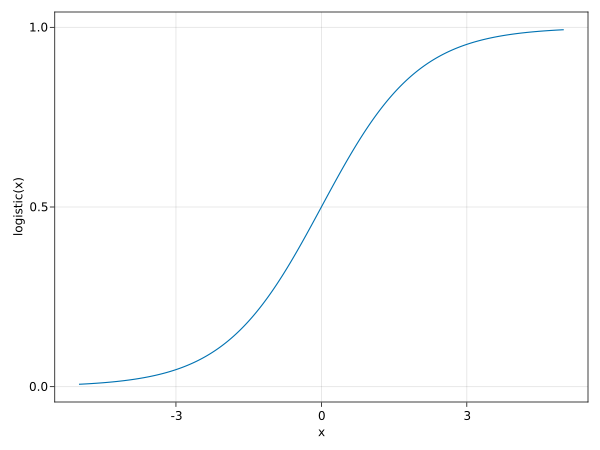

In [26]:
lines(xvals, logistic.(xvals), axis=(xlabel="x", ylabel="logistic(x)"))

- Notice the '.' after `logistic` and before `(xvals)`, which vectorizes the call

## Timings
- The `BenchmarkTools` package provides macros to help with benchmarking evaluation of an expression.

In [27]:
using BenchmarkTools

## Call `@benchmark` on an expression

In [28]:
@benchmark logistic(1.3)

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  0.013 ns … 0.032 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     0.015 ns             ┊ GC (median):    0.00%
 Time  (mean ± σ):   0.015 ns ± 0.001 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                        █           ▂                        
  ▂▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▂ ▂
  013 ns         Histogram: frequency by time        018 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [29]:
versioninfo()  # some specs on the computer being used

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, tigerlake)


### In practice this is just benchmarking the exp function

In [30]:
@benchmark exp(-1.3)

BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  0.013 ns … 2.082 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     0.016 ns             ┊ GC (median):    0.00%
 Time  (mean ± σ):   0.017 ns ± 0.029 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▆   █  █   ▇  ▅   ▂      ▁                             ▂
  ▅▁▁█▁▁▁█▁▁█▁▁▁█▁▁█▁▁▁█▁▁▇▁▁▁█▁▁▁▇▁▁█▁▁▁█▁▁▆▁▁▁▇▁▁▆▁▁▁▇▁▁▁ █
  013 ns      Histogram: log(frequency) by time      029 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

## Benchmark the vectorized form

In [31]:
length(xvals)

501

In [32]:
@benchmark logistic.(xvals)

BenchmarkTools.Trial: 10000 samples with 7 evaluations.
 Range (min … max):  4.164 μs … 639.347 μs  ┊ GC (min … max): 0.00% … 98.06%
 Time  (median):     4.284 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.820 μs ±  12.355 μs  ┊ GC (mean ± σ):  5.06% ±  1.96%

  ▆█▇▄▁   ▁▂▁   ▂▃▄▃▃▃▂▁                                      ▁
  █████▇▆▇███▆▄█████████▇███████▆▆▅▅▄▄▃▄▄▄▆▅▆▆▅▄▅▃▄▅▄▅▄▅▄▃▄▄▅ █
  4.16 μs      Histogram: log(frequency) by time      7.68 μs <

 Memory estimate: 4.25 KiB, allocs estimate: 4.

## Wow, that took several microseconds. Why so long?
- The median time for evaluating `logistic` on an array of length 501 is tens of thousands of times greater than a single evaluation.
- The timings for `logistic(1.3)` already had the value `1.3` in a register.
- It would be more realistic to time on a single element of the array so the time for fetching from memory is included

In [33]:
@benchmark logistic(xvals[231])

BenchmarkTools.Trial: 10000 samples with 994 evaluations.
 Range (min … max):  31.617 ns …  4.967 μs  ┊ GC (min … max): 0.00% … 99.13%
 Time  (median):     32.805 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   38.528 ns ± 98.205 ns  ┊ GC (mean ± σ):  5.08% ±  1.98%

  ▅█▅▂   ▃▂  ▂▃▄▄▄▃▂▂▁▂▂▁▁▁                                   ▁
  █████████████████████████▇█▇▇█▇▇██▇▇▇▆▇▆▅▅▅▆▆▆▆▅▆▆▆▄▄▅▅▄▄▄▅ █
  31.6 ns      Histogram: log(frequency) by time      64.1 ns <

 Memory estimate: 32 bytes, allocs estimate: 2.

### Sometimes it can be cheaper to expand the iterator to an array

In [34]:
xvals = collect(xvals)   # collect all the values in a vector
typeof(xvals)

Vector{Float64} (alias for Array{Float64, 1})

In [35]:
@benchmark logistic.(xvals)

BenchmarkTools.Trial: 10000 samples with 9 evaluations.
 Range (min … max):  2.390 μs … 466.510 μs  ┊ GC (min … max): 0.00% … 98.23%
 Time  (median):     2.562 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.823 μs ±   8.889 μs  ┊ GC (mean ± σ):  6.22% ±  1.96%

    ▃█▆▃▂                                                      
  ▂▄█████▇▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▂▂▂▂▂ ▃
  2.39 μs         Histogram: frequency by time        4.45 μs <

 Memory estimate: 4.09 KiB, allocs estimate: 3.

### The time for evaluation of a single element has not changed much

In [36]:
@benchmark logistic(xvals[231])

BenchmarkTools.Trial: 10000 samples with 995 evaluations.
 Range (min … max):  26.870 ns …  10.121 μs  ┊ GC (min … max): 0.00% … 99.56%
 Time  (median):     28.041 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   33.363 ns ± 124.235 ns  ┊ GC (mean ± σ):  6.08% ±  1.72%

  ▅█▆▃▁▁ ▄▃▁  ▂▃▄▅▅▄▃▂▂▁▁▁                                     ▂
  █████████████████████████▇█▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▆▆▇▆▆▆▆▆▅▆▆▆▇▆▅ █
  26.9 ns       Histogram: log(frequency) by time      53.8 ns <

 Memory estimate: 32 bytes, allocs estimate: 2.

## Mutating functions
- One of the bottlenecks with dynamic languages can be excessive allocation/garbage collection of intermediate values.
- `R` can be especially problematic in this regard.
- A common Julia coding pattern is to provide one version of a function that overwrites an argument with the values calculated from the other argument(s).
- By convention, the names of such *mutating* functions end in `!`, and the argument(s) being mutated are listed first.

In [37]:
function logistic!(y::AbstractArray{T}, x::AbstractArray{T}) where {T<:AbstractFloat}
    @. y = inv(one(T) + exp(-x)) # @. adds dots to all operators & calls
end
yvals = similar(xvals);   # array of the same size and type
logistic!(yvals, xvals);

In [38]:
all(yvals ≈ logistic.(xvals))  # check that the values are approximately equal

true

In [39]:
first(yvals, 8)   # like `head` in R

8-element Vector{Float64}:
 0.0066928509242848554
 0.00682713242213816
 0.006964089177762089
 0.007103773724388775
 0.007246239595831429
 0.007391541344281971
 0.007539734558373393
 0.0076908758815083305

### Benchmark the mutating method

In [40]:
@benchmark logistic!(yvals, xvals)

BenchmarkTools.Trial: 10000 samples with 9 evaluations.
 Range (min … max):  2.067 μs …   5.404 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.114 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.176 μs ± 126.786 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▂██             ▁▃▁                                        
  ▁▃████▃▁▁▁▁▁▁▁▁▁▂▅███▅▂▁▁▁▁▁▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  270 μs          Histogram: frequency by time        2.54 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

- Notice that there are no allocations of memory and hence 0% of the time is spent in garbage collection (GC)

## But wait, there's more

- Because the compilation is being performed within the Julia system, skilled users can experiment with it.
- Modern processors provide for many forms of parallelism including what is known as "single instruction, multiple data" (SIMD) instructions.  (Called SSE, SSE2, AVX, for floating point.)
- `LoopVectorization.jl` is the beginning of exploration of some of these optimizations

In [41]:
using LoopVectorization

### Massive changes to the code are required :-)

In [42]:
function logistic!(y::AbstractArray{T}, x::AbstractArray{T}) where {T<:AbstractFloat}
    @turbo @. y = inv(one(T) + exp(-x))
end

logistic! (generic function with 1 method)

In [43]:
@benchmark logistic!($yvals, $xvals)

BenchmarkTools.Trial: 10000 samples with 227 evaluations.
 Range (min … max):  327.269 ns … 436.392 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     336.930 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   338.491 ns ±   7.729 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂▂▅          ▅ █      ▁      ▃            ▁ ▄                 ▁
  ███▁▃▁▁▁▄▅▃▅▅███▆▆▆▆▅▇█▇▆▆▆▇▆█▆▆▆▆▇▅▆▆▆▆▆▆███▆▅▇▇▆▅▆▆▆▆▇▇▆▇▇▇ █
  327 ns        Histogram: log(frequency) by time        365 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

### Implementation methods and method instances

In [44]:
methods(logistic!)

# 1 method for generic function "logistic!":
[1] logistic!(y::AbstractArray{T, N} where N, x::AbstractArray{T, N} where N) where T<:AbstractFloat in Main at In[42]:1

In [45]:
methodinstances(logistic!)

1-element Vector{Core.MethodInstance}:
 MethodInstance for logistic!(::Vector{Float64}, ::Vector{Float64})

## How it's going

In [46]:
@code_native logistic!(yvals, xvals)

	.text
; ┌ @ In[42]:1 within `logistic!'
	pushq	%rax
	movq	%rsi, (%rsp)
	movb	$1, %al
; │ @ In[42]:2 within `logistic!'
; │┌ @ broadcast.jl:393 within `vmaterialize!'
; ││┌ @ broadcast.jl:393 within `macro expansion'
; │││┌ @ refvalue.jl:56 within `getindex'
; ││││┌ @ Base.jl:33 within `getproperty'
	testb	%al, %al
	je	L1385
; ││└└└
; ││┌ @ Base.jl within `macro expansion'
	movq	(%rsi), %rax
	movq	8(%rsi), %rcx
; ││└
; ││┌ @ broadcast.jl:393 within `macro expansion'
; │││┌ @ stridedpointers.jl:91 within `stridedpointer_preserve'
; ││││┌ @ stridedpointers.jl:40 within `memory_reference' @ stridedpointers.jl:42
; │││││┌ @ abstractarray.jl:1116 within `pointer'
; ││││││┌ @ pointer.jl:65 within `unsafe_convert'
	movq	(%rax), %rdx
; │││└└└└
; │││┌ @ abstractarray.jl:89 within `axes'
; ││││┌ @ array.jl:133 within `size'
	movq	24(%rax), %r8
; │││└└
; │││┌ @ stridedpointers.jl:91 within `stridedpointer_preserve'
; ││││┌ @ broadcast.jl:99 within `memory_reference' @ stridedpointers.jl:40 @ stri

# Summary
- All functions in Julia are *generic* and use *multiple dispatch*
- A generic has one or more implementation methods, as returned by `methods()`.
- Just-In-Time (JIT) compilation is performed on *method instances*, which are specific to the argument *signature* as concrete types
- There are many steps from a method implementation to a compiled method instance.  Many of these steps are in Julia code, not llvm.
- Some incredible tools for enhancing Julia code are being written in Julia.

![One does not](assets/5hs27j.jpg)